In [37]:
import copy
import numpy as np
import sys
import json

custom_module_path = "/home/rebeccaz/Github/vampires_calibration"
sys.path.append(custom_module_path)

import instruments as inst

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [38]:
file_path = "/home/rebeccaz/Github/vampires_calibration/data/20230914_processed_table.csv"
wavelength_string = 670
wavelength_index = 1
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
# print("Interleaved Values")
# print("Length: ", len(interleaved_values))
# print(interleaved_values)
# print("Interleaved Stds")
# print("Length: ", len(interleaved_stds))
# print(interleaved_stds[0 : 10])
# print("Configuration List")
# print("Length: ", len(configuration_list))
# print(configuration_list)
# print(interleaved_stds[0])

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [39]:
# From MCMC
# txt_save_file_path = "/home/rebeccaz/Github/vampires_calibration/mcmc/results/FLC_0_43_dichroic_theta_0_pm_10_optics_theta_0_optics_retardance_025/" + str(610) + "nm_Adjusted_EM_Gain.txt"
# From scipy.minimize
# txt_save_file_path = "/home/rebeccaz/Github/vampires_calibration/scipy_minimize/data_files/produced/FLC_0_to_43_ten_percent_retardance_constraints_dichroic_theta_0_optics_theta_0_reduced_errors/" + str(wavelength_index) + "nm_ten_percent_retardance_constraints_dichroic_theta_0_optics_theta_0_reduced_errors.txt"
txt_save_file_path = txt_save_file_path = "/home/rebeccaz/Github/vampires_calibration/scipy_minimize/data_files/produced/FLC_0_to_43_ten_percent_retardance_constraints_dichroic_theta_0_optics_theta_0_reduced_errors/670nm_ten_percent_retardance_constraints_dichroic_theta_0_optics_theta_0_reduced_errors.txt"
deltas_in_waves = False

# Loading in previous fit from vampires_calibration
with open(txt_save_file_path, "r") as f:
    past_fit = json.load(f)

theta_pol = past_fit["lp"]["theta"]
delta_HWP = past_fit["hwp"]["phi"] 
offset_HWP = past_fit["hwp"]["delta_theta"]
delta_derot = past_fit["image_rotator"]["phi"] 
delta_opts = past_fit["optics"]["phi"] 
epsilon_opts = past_fit["optics"]["epsilon"]
rot_opts = past_fit["optics"]["theta"]
delta_FLC = past_fit["flc"]["phi"] 
rot_FLC = past_fit["flc"]["delta_theta"]
delta_dichroic = past_fit["dichroic"]["phi"]
epsilon_dichroic = past_fit["dichroic"]["epsilon"]
rot_dichroic = past_fit["dichroic"]["theta"]

if deltas_in_waves:
    delta_HWP = delta_HWP * 2 * np.pi
    delta_derot = delta_derot * 2 * np.pi
    delta_opts = delta_opts * 2 * np.pi
    delta_FLC = delta_FLC * 2 * np.pi
    delta_dichroic = delta_dichroic * 2 * np.pi

IPOL_em_gains = [1.14, 1.18, 1.18, 1.18]
MBI_em_gains = [1.23, 1.19, 1.2, 1.08]
if obs_mode == "IPOL":
    em_gain = IPOL_em_gains[wavelength_index]
elif obs_mode == "MBI":
    em_gain = MBI_em_gains[wavelength_index]


system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {
                "phi": delta_dichroic,
                "epsilon": epsilon_dichroic,
                "theta": rot_dichroic,
            },
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {
                "phi": delta_FLC,
                "theta": 0,  # not fitted
                "delta_theta": rot_FLC,
            },
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {
                "phi": delta_opts,
                "epsilon": epsilon_opts,
                "theta": rot_opts,
            },
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {
                "phi": delta_derot,
            },
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {
                "phi": delta_HWP,
                "delta_theta": offset_HWP,
            },
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}






In [40]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.58842619 0.58763215 0.03055878 0.        ]
 [0.58842619 0.58763215 0.03055878 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

1.19
logl value: 603645.6500580516


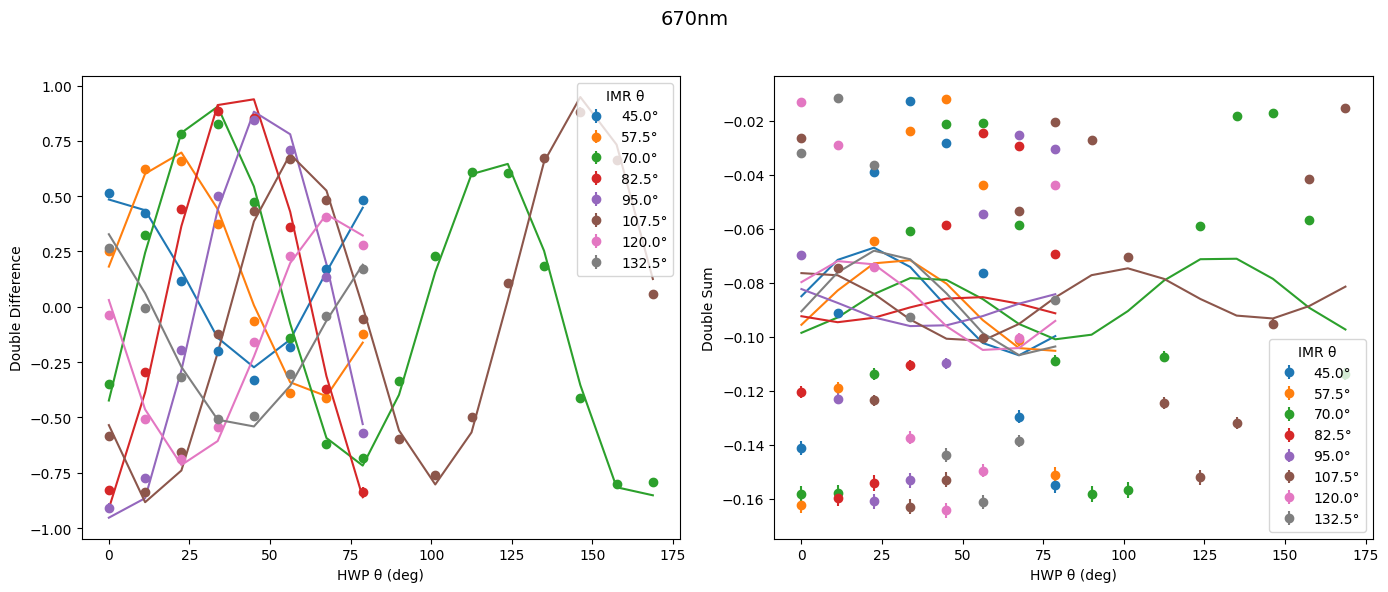

In [41]:
p0 = {
    "wollaston": {"transmission_ratio": em_gain}, 
    # "flc": {"phi": 2 * np.pi * delta_FLC, "delta_theta": rot_FLC},
    # "optics": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    # "image_rotator": {"phi": 2 * np.pi * delta_derot, "delta_theta": offset_derot},
    # "hwp": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP},
    # "lp": {"theta": 0}
}

print(em_gain)

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)